In [2]:
# !pip3 install --upgrade pip
# !pip3 install tensorflow-quantum

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq
import sympy
import numpy as np
import cirq

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [2]:
cirq.__version__

'0.9.1'

In [3]:
a, b = sympy.symbols('a b')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


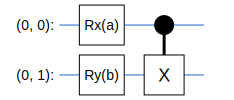

In [4]:
# Create two qubits
q0, q1 = cirq.GridQubit.rect(1, 2)

# Create a circuit on these qubits using the parameters you created above.
circuit = cirq.Circuit(
    cirq.rx(a).on(q0),
    cirq.ry(b).on(q1), cirq.CNOT(control=q0, target=q1))

SVGCircuit(circuit)

In [5]:
# Calculate a state vector with a=0.5 and b=-0.5.
resolver = cirq.ParamResolver({a: 0.5, b: -0.5})
output_state_vector = cirq.Simulator().simulate(circuit, resolver).final_state_vector
output_state_vector

array([ 0.9387913 +0.j        , -0.23971277+0.j        ,
        0.        +0.06120872j,  0.        -0.23971277j], dtype=complex64)

In [6]:
z0 = cirq.Z(q0)

qubit_map={q0: 0, q1: 1}

z0.expectation_from_state_vector(output_state_vector, qubit_map).real

0.8775825500488281

In [7]:
z0x1 = 0.5 * z0 + cirq.X(q1)

z0x1.expectation_from_state_vector(output_state_vector, qubit_map).real

-0.04063427448272705

In [8]:
# Rank 1 tensor containing 1 circuit.
circuit_tensor = tfq.convert_to_tensor([circuit])

print(circuit_tensor.shape)
print(circuit_tensor.dtype)

(1,)
<dtype: 'string'>


In [9]:
# Rank 1 tensor containing 2 Pauli operators.
pauli_tensor = tfq.convert_to_tensor([z0, z0x1])
pauli_tensor.shape

TensorShape([2])

In [10]:
batch_vals = np.array(np.random.uniform(0, 2 * np.pi, (5, 2)), dtype=np.float32)

In [11]:
cirq_results = []
cirq_simulator = cirq.Simulator()

for vals in batch_vals:
    resolver = cirq.ParamResolver({a: vals[0], b: vals[1]})
    final_state_vector = cirq_simulator.simulate(circuit, resolver).final_state_vector
    cirq_results.append(
        [z0.expectation_from_state_vector(final_state_vector, {
            q0: 0,
            q1: 1
        }).real])

print('cirq batch results: \n {}'.format(np.array(cirq_results)))

cirq batch results: 
 [[ 0.99393952]
 [ 0.99954301]
 [-0.62273693]
 [-0.46576166]
 [-0.68627167]]


In [12]:
tfq.layers.Expectation()(circuit,
                         symbol_names=[a, b],
                         symbol_values=batch_vals,
                         operators=z0)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.99393964],
       [ 0.9995431 ],
       [-0.62273747],
       [-0.46576226],
       [-0.6862705 ]], dtype=float32)>